# Model 1
Nasz pierwszy model oparty jest na systemie porównującym podobnych użytkowników.

In [70]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

##### Nasze dane:

In [71]:
genome_scores = pd.read_csv('ml-latest/genome-scores.csv')
genome_tags = pd.read_csv('ml-latest/genome-tags.csv')
links = pd.read_csv('ml-latest/links.csv')
tags = pd.read_csv('ml-latest/tags.csv')

In [72]:
ratings = pd.read_csv('ml-latest/ratings.csv')
movies = pd.read_csv("movies_FINAL.csv")
  
n_ratings = len(ratings)
n_movies = len(ratings['movieId'].unique())
n_users = len(ratings['userId'].unique())

In [4]:
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 27753444
Number of unique movieId's: 53889
Number of unique users: 283228
Average ratings per user: 97.99
Average ratings per movie: 515.01


In [5]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,16
1,2,15
2,3,11
3,4,736
4,5,72


### 1. Tworzenie modelu

In [73]:
# lista ze srednimi z ocen filmow
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

ratings[ratings['movieId']==highest_rated]
ratings[ratings['movieId']==lowest_rated]

movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [74]:
from scipy.sparse import csr_matrix

def create_matrix(df):
      
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())
      
    # Map Ids to indices
    # dict( pair: id, list )
    user_mapper = dict( zip( np.unique(df["userId"]), list(range(N)) ) )    # N - liczba uzytkownikow
    movie_mapper = dict( zip( np.unique(df["movieId"]), list(range(M)) ) )  # M - liczba filmow

    # Map indices to IDs
    # to co wyzej, tylko pary na odwrot
    user_inv_mapper = dict( zip( list(range(N)), np.unique(df["userId"]) ) )
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
      
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

#     X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    X = csr_matrix((df["rating"], (user_index, movie_index)), shape=(N, M))#, dtype=np.float32)

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [75]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)

#### Funkcja zwracająca podobnych użytkowników

In [76]:
def find_similar_users(user_id, X, k, metric='cosine', show_distance=False):
    neighbour_ids = []
      
    user_ind = user_mapper[user_id]
    user_vec = X[user_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    user_vec = user_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(user_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(user_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [10]:
user_id = 1
similar_ids = find_similar_users(user_id, X, k=10)
print("Your movie preferences are similar to users:\n")
for i in similar_ids:
    print(i)

Your movie preferences are similar to users:

69380
24743
279985
47864
245536
89732
269173
49501
264168
70866


Szybka weryfikacja:

In [11]:
rates_1 = ratings[ratings["userId"] == 1]
rates_1 = rates_1.drop(['timestamp', 'userId'], axis=1)
rates_1 = rates_1.set_index('movieId')
rates_1

,rating
movieId,
307,3.5
481,3.5
1091,1.5
1257,4.5
1449,4.5
1590,2.5
1591,1.5
2134,4.5
2478,4.0


In [12]:
rates_69380 = ratings[ratings["userId"] == 69380]
rates_69380 = rates_69380.drop(['timestamp', 'userId'], axis=1)
rates_69380 = rates_69380.set_index('movieId')
rates_69380

,rating
movieId,
88,3.0
481,3.5
637,0.5
1100,4.5
1347,2.0
1350,4.0
1911,2.0
2109,4.0
2126,2.0


In [13]:
rates_1.join(rates_69380, lsuffix='_1', rsuffix='_69380', on='movieId', how='inner')

,rating_1,rating_69380
movieId,,
481,3.5,3.5
2478,4.0,4.0
3020,4.0,3.5
3424,4.5,3.0
3698,3.5,5.0


Wygląda ok :)

#### Funkcja zwracająca rekomendacje fimów

In [77]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

def recommend_movies(user_id, num_users=10, rating=5):
    """
    user_id - id of the user
    num_users - number of similar users
    rating - min. rating of the movies
    """
    
    X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)
    similar_ids = find_similar_users(user_id, X, k=num_users)
#     print(similar_ids)
    
    # oceny filmow, srednie
    rates = pd.concat([pd.DataFrame(
        ratings[ratings['userId'] == i].drop(['timestamp', 'userId'], axis=1),
        columns=['movieId', 'rating']) for i in similar_ids ])
    rates = rates.groupby(['movieId'], as_index=False).mean().sort_values(by=['rating'], ascending=False)             
#     print(rates)
    
    # filmy ktore usuniemy
    remove = ratings[ratings['userId'] == user_id].movieId
#     print(remove)
    
    result = rates[rates['rating'] >= rating]
    result = result[~result['movieId'].isin(remove)]
    result = [(mid,movie_titles[mid]) for mid in result.movieId]
    result = sorted(result, key=lambda tup: tup[0])
#     print(*result, sep='\n')
    return result


#### Testowanie

In [15]:
user_id = 1
recommendations = recommend_movies(user_id)
print(f"User {user_id}, there are {len(recommendations)} recommendations for you.")
print(f"You might like movies:")
for movie in recommendations:
    print(movie)

User 1, there are 9 recommendations for you.
You might like movies:
(60, 'Indian in the Cupboard, The')
(65, 'Bio-Dome')
(318, 'Shawshank Redemption, The')
(1077, 'Sleeper')
(1476, 'Private Parts')
(1945, 'On the Waterfront')
(2329, 'American History X')
(37240, 'Why We Fight')
(99114, 'Django Unchained')


#### Badanie działania hiperparametrów

In [16]:
user_id = 10
recommendations = recommend_movies(user_id)
print(f"User {user_id}, there are {len(recommendations)} recommendations for you.")
print(f"You might like movies:")
for movie in recommendations:
    print(movie)

User 10, there are 51 recommendations for you.
You might like movies:
(123, 'Chungking Express (Chung Hing sam lam)')
(154, 'Beauty of the Day (Belle de jour)')
(307, 'Three Colors: Blue (Trois couleurs: Bleu)')
(308, 'Three Colors: White (Trzy kolory: Bialy)')
(441, 'Dazed and Confused')
(556, 'War Room, The')
(602, 'Great Day in Harlem, A')
(949, 'East of Eden')
(1059, "William Shakespeare's Romeo + Juliet")
(1147, 'When We Were Kings')
(1178, 'Paths of Glory')
(1185, 'My Left Foot')
(1203, '12 Angry Men')
(1209, "Once Upon a Time in the West (C'era una volta il West)")
(1211, 'Wings of Desire (Himmel über Berlin, Der)')
(1303, 'Man Who Would Be King, The')
(1394, 'Raising Arizona')
(1411, 'Hamlet')
(1615, 'Edge, The')
(1633, "Ulee's Gold")
(1719, 'Sweet Hereafter, The')
(1734, 'My Life in Pink (Ma vie en rose)')
(1914, 'Smoke Signals')
(1933, 'Life of Emile Zola, The')
(1949, 'Man for All Seasons, A')
(2066, 'Out of the Past')
(2067, 'Doctor Zhivago')
(2068, 'Fanny and Alexander (Fa

In [17]:
user_id = 10
recommendations = recommend_movies(user_id, 20, 5)
print(f"User {user_id}, there are {len(recommendations)} recommendations for you.")
print(f"You might like movies:")
for movie in recommendations:
    print(movie)

User 10, there are 40 recommendations for you.
You might like movies:
(441, 'Dazed and Confused')
(556, 'War Room, The')
(602, 'Great Day in Harlem, A')
(861, 'Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha)')
(929, 'Foreign Correspondent')
(947, 'My Man Godfrey')
(1059, "William Shakespeare's Romeo + Juliet")
(1178, 'Paths of Glory')
(1411, 'Hamlet')
(1615, 'Edge, The')
(1633, "Ulee's Gold")
(1719, 'Sweet Hereafter, The')
(1734, 'My Life in Pink (Ma vie en rose)')
(1933, 'Life of Emile Zola, The')
(2066, 'Out of the Past')
(2067, 'Doctor Zhivago')
(2115, 'Indiana Jones and the Temple of Doom')
(2239, "Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto)")
(2285, 'If....')
(2682, 'Limbo')
(2691, "Legend of 1900, The (a.k.a. The Legend of the Pianist on the Ocean) (Leggenda del pianista sull'oceano)")
(2693, 'Trekkies')
(2731, '400 Blows, The (Les quatre cents coups)')
(2867, 'Fright Night')
(2927, 'Brief Encounter')
(2952, 'Sydney (Hard Ei

In [18]:
user_id = 10
recommendations = recommend_movies(user_id, 100, 5)
print(f"User {user_id}, there are {len(recommendations)} recommendations for you.")
print(f"You might like movies:")
for movie in recommendations:
    print(movie)

User 10, there are 66 recommendations for you.
You might like movies:
(83, 'Once Upon a Time... When We Were Colored')
(127, 'Silences of the Palace, The (Saimt el Qusur)')
(449, 'Fear of a Black Hat')
(456, 'Fresh')
(961, 'Little Lord Fauntleroy')
(987, 'Bliss')
(997, 'Caught')
(1151, 'Lesson Faust')
(1533, 'Promise, The (La promesse)')
(1572, 'Contempt (Mépris, Le)')
(1615, 'Edge, The')
(1726, 'Postman, The')
(1809, 'Fireworks (Hana-bi)')
(1814, 'Price Above Rubies, A')
(1901, 'Dear Jesse')
(1933, 'Life of Emile Zola, The')
(1935, 'How Green Was My Valley')
(1991, "Child's Play")
(2041, 'Condorman')
(2066, 'Out of the Past')
(2106, 'Swing Kids')
(2204, 'Saboteur')
(2261, 'One Crazy Summer')
(2346, 'Stepford Wives, The')
(2351, 'Nights of Cabiria (Notti di Cabiria, Le)')
(2356, 'Celebrity')
(2587, 'Life')
(2691, "Legend of 1900, The (a.k.a. The Legend of the Pianist on the Ocean) (Leggenda del pianista sull'oceano)")
(2736, 'Brighton Beach Memoirs')
(2843, 'Black Cat, White Cat (Crna 

### 2. Walidacja

In [78]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

def recommend_movies_validation(user_id, movie_id, num_users=10, rating=5):
    """
    user_id - id of the user
    movie_id - id of the removed movie
    num_users - number of similar users
    rating - min. rating of the movies
    """
    
    # uzytkownicy ktorzy obejrzeli dany film
    users = ratings[ratings['movieId']==movie_id].userId
    
    # ratings tylko z powyzszymi uzytkownikami oraz z usunietym danym filmem
    ratings2 = ratings[ratings['userId'].isin(users)]
    ratings2 = ratings2[(ratings2['movieId']!=movie_id) | (ratings2['userId']!=user_id)]
    
    X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings2)
    
    # sposrod powyzszych uzytkownikow wybieramy tych podobnych do naszego
    similar_ids = find_similar_users(user_id, X, k=num_users)
    
    # srednie oceny filmow (ocenione przez uzytkowników)
    rates = pd.concat([pd.DataFrame(
        ratings[ratings['userId'] == i].drop(['timestamp', 'userId'], axis=1),
        columns=['movieId', 'rating']) for i in similar_ids ])
    rates = rates.groupby(['movieId'], as_index=False).mean().sort_values(by=['rating'], ascending=False)             

    # filmy ktore uzytkownik juz widzial
#     remove = ratings[ratings['userId'] == user_id].movieId

    # zostawiamy filmy ktore maja ocene o min wartosci `rating`...
    result = rates[rates['rating'] >= rating]
    # ... oraz ktorych uzytkownik nie widzial
#     result = result[~result['movieId'].isin(remove)]
    # zostawiamy tylko kolumne `movieId`
    result = [mid for mid in result.movieId]

    # sprawdzamy czy sztucznie usuniety dany film pojawi sie w rekomendacjach
    return movie_id in result

In [20]:
user_id = 10
print(ratings[ratings['userId']==user_id])

      userId  movieId  rating  timestamp
939       10        1     5.0  948885850
940       10       32     3.0  948887531
941       10       43     4.0  948883986
942       10       47     4.0  948881454
943       10       50     5.0  948882791
...      ...      ...     ...        ...
1055      10     3203     3.0  948883834
1056      10     3246     3.0  948882395
1057      10     3253     3.0  948881454
1058      10     3260     3.0  948882230
1059      10     3265     4.0  948882177

[121 rows x 4 columns]


In [21]:
result = recommend_movies_validation(user_id, 1, 100, 3.5)
print(result)

True


In [87]:
def recommendation_fit(user_id, num_sim_users=10, rating=5):
    
    good_movies = ratings[(ratings['userId']==user_id) & (ratings['rating']>=rating)].movieId
#     print(good_movies)
    bad_movies = ratings[(ratings['userId']==user_id) & (ratings['rating']<rating)].movieId
#     print(bad_movies)
    
    movies_true = [recommend_movies_validation(user_id, movie_id, num_sim_users, rating) for movie_id in good_movies]  
    movies_false = [not recommend_movies_validation(user_id, movie_id, num_sim_users, rating) for movie_id in bad_movies]  
    
    return movies_true, movies_false

In [22]:
rec_100 = recommendation_fit(10, 100, 3.5)
print(rec_100)

([True, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, False, False, False, False, False, True, True, True, False, True, True, True, True, False, True, False, True, True, False, True, True, False], [False, False, False, False, False, False, False, False, True, False, False, True, True, False, True, False, False, True, False, False, True, False])


In [23]:
rec_20 = recommendation_fit(10, 20, 3.5)
print(rec_20)

([False, False, True, True, True, True, False, False, True, False, True, False, False, True, True, True, True, False, True, True, False, False, True, True, False, True, True, False, True, False, True, False, False, True, True, True, True, True, False, False, True, False, False, True, True, False, True, False, True, False, True, True, False, True, True, False, True, True, False, False, True, False, True, True, False, False, False, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, True, False, False, False, False, False, True, True, False, False, False, True, False, False, True, False, False], [True, True, True, False, True, False, False, False, True, True, False, True, True, True, True, False, False, False, True, True, True, True])


In [24]:
rec_100_5 = recommendation_fit(10, 100, 5)
print(rec_100_5)

([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True], [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True])


In [80]:
def make_pred_real(data_touple):
    (data_true, data_false) = data_touple
    y = [1 for i in range(len(data_true))] + [0 for i in range(len(data_false))]
    y_pred = data_true + data_false
    
    return (y, y_pred)

#### Confusion matrix i metryki

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y_true, y_pred):
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    cm.plot(colorbar=False)
    
    plt.show()

In [82]:
def lab_recall_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    (tn, fn, fp, tp) = (cm[0][0], cm[1][0], cm[0][1], cm[1][1])
    return tp/(tp+fn)

def lab_precission_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    (tn, fn, fp, tp) = (cm[0][0], cm[1][0], cm[0][1], cm[1][1])
    return tp/(tp+fp)

def lab_f1_score(y_true, y_pred):
    pre = lab_precission_score(y_true, y_pred)
    rec = lab_recall_score(y_true, y_pred)
    return (2*pre*rec)/(pre+rec)


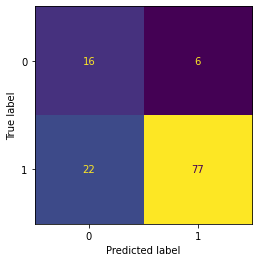

Recall: 0.7777777777777778
Precission: 0.927710843373494
F1: 0.8461538461538461


In [83]:
(y_true, y_pred) = make_pred_real(rec_100)

plot_cm(y_true, y_pred)
print('Recall:', lab_recall_score(y_true, y_pred))
print('Precission:', lab_precission_score(y_true, y_pred))
print('F1:', lab_f1_score(y_true, y_pred))


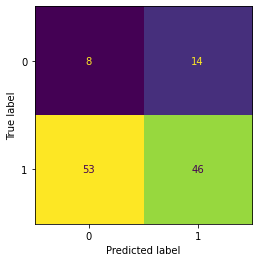

Recall: 0.46464646464646464
Precission: 0.7666666666666667
F1: 0.5786163522012578


In [84]:
(y_true, y_pred) = make_pred_real(rec_20)

plot_cm(y_true, y_pred)
print('Recall:', lab_recall_score(y_true, y_pred))
print('Precission:', lab_precission_score(y_true, y_pred))
print('F1:', lab_f1_score(y_true, y_pred))


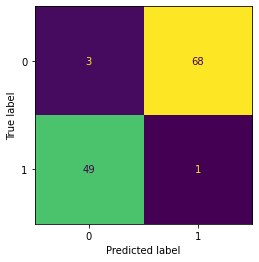

Recall: 0.02
Precission: 0.014492753623188406
F1: 0.01680672268907563


In [85]:
(y_true, y_pred) = make_pred_real(rec_100_5)

plot_cm(y_true, y_pred)
print('Recall:', lab_recall_score(y_true, y_pred))
print('Precission:', lab_precission_score(y_true, y_pred))
print('F1:', lab_f1_score(y_true, y_pred))


#### Walidacja na kilku użytkownikach 

In [ ]:
rec_100_us20 = recommendation_fit(10, 100, 3.5)
print(rec_100_us20)

In [ ]:
(y_true, y_pred) = make_pred_real(rec_100_us20)

plot_cm(y_true, y_pred)
print('Recall:', lab_recall_score(y_true, y_pred))
print('Precission:', lab_precission_score(y_true, y_pred))
print('F1:', lab_f1_score(y_true, y_pred))


In [50]:
len(ratings['userId'].unique())
# 114819
#  45791
# 283228

283228

In [92]:
import random

def recommendation_group_fit(n_users=2, num_sim_users=10, rating=5):
#     users = random.choices(range(1,283228), k=n_users)
    users = random.choices(ratings['userId'].unique(), k=n_users)
    print(users)

    data_true, data_false = [],[]

    for user in users:
        a,b = recommendation_fit(user, num_sim_users, rating)
#         print(a,b)
#         (a,b) = ([True, True, True, False], [True, True, False, True, False])
#         (a,b) = rec_100
        data_true += a
        data_false += b
        
    return data_true, data_false
#     return

# group = 
recommendation_group_fit(10, 100, 3.5)
# print(group)

[275204, 63410, 120965, 171052, 187342, 32566, 176429, 214274, 17816, 79789]


IndexError: row index (275203) out of range

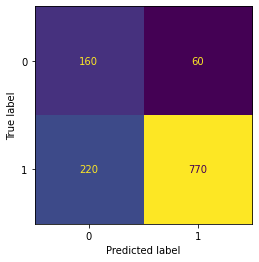

Recall: 0.7777777777777778
Precission: 0.927710843373494
F1: 0.8461538461538461


In [91]:
(y_true, y_pred) = make_pred_real(group)

plot_cm(y_true, y_pred)
print('Recall:', lab_recall_score(y_true, y_pred))
print('Precission:', lab_precission_score(y_true, y_pred))
print('F1:', lab_f1_score(y_true, y_pred))
